In [1]:
using Random
using DataFrames
using CSV

In [2]:
function build_lattice_df(Lx,Ly)
    
    N = Lx*Ly
    sites = collect(1:N)
    dirs = ['x','y']
    interactions = DataFrame(["$site,$dir" => [] for site in sites for dir in dirs])    
    for site in 1:N
        up = mod(site-1-Lx,N)
        down = mod(site-1+Lx,N)
        right = Int(((site-1)-((site-1)%Lx)) + mod(((site-1)%Lx)+1,Lx))
        left = Int(((site-1)-((site-1)%Lx)) + mod(((site-1)%Lx)-1,Lx))
        push!(interactions[!,"$site,x"],[left+1,right+1])
        push!(interactions[!,"$site,y"],[up+1,down+1])
    end
    
    return interactions
end

build_lattice_df (generic function with 1 method)

In [3]:
function rows_and_columns(Lx,Ly)
    
    N =Lx*Ly
    rows = DataFrame(["row$row" => [] for row in 1:Ly])    
    cols = DataFrame(["col$col" => [] for col in 1:Lx])
    for site in 1:N
        row = Int((((site-1) - ((site-1)%Lx))/Ly)+1)
        col = Int(((site-1) % Lx)+1)
        push!(rows[!,"row$row"],site)
        push!(cols[!,"col$col"],site)
    end
    
    return rows, cols
end

rows_and_columns (generic function with 1 method)

In [4]:
function Calculate_XY_Energy(config,interactions)
    
    N = length(config)
    totalenergy = 0
    
    for site in (1:N)
        neighbors_x = interactions[!,"$site,x"][1,1]
        neighbors_y = interactions[!,"$site,y"][1,1]
        energy_contributions_x = 0.5*-1*cos.(config[site].-config[neighbors_x])
        energy_contributions_y = 0.5*-1*cos.(config[site].-config[neighbors_y])
        totalenergy += sum(energy_contributions_x) + sum(energy_contributions_y)
    end
    
    return totalenergy

end

Calculate_XY_Energy (generic function with 1 method)

In [131]:
test1 = ones(256)*0.5;
interactions = build_lattice_df(16,16);
test_energy = Calculate_XY_Energy(test1,interactions)

-512.0

In [74]:
function XY_update_function(config,energy,interactions,beta,energy_func)
    
    random_angles =rand(Float64,length(config))*2*pi
#     new_config = mod2pi.(copy(config).+random_angles)
    new_energy = energy_func(random_angles,interactions)
    deltaE = new_energy-energy
    exp_beta_deltaE = exp(-1*beta*deltaE)
    rand_value = rand(Float64,1)[1]
    delta_accept_count = 0
    
    if exp_beta_deltaE > rand_value
        config = random_angles
        delta_accept_count += 1
    else
        deltaE = 0.
    end
    
    return config, deltaE, delta_accept_count
end

XY_update_function (generic function with 1 method)

In [104]:
test2 = rand(Float64,4^2)*2pi;
interactions = build_lattice_df(4,4);
@time begin
test_energy2 = Calculate_XY_Energy(test2,interactions)
end
@time begin
XY_update_function(test2,test_energy2,interactions,1,Calculate_XY_Energy)
end

  0.000109 seconds (480 allocations: 20.750 KiB)
  0.000116 seconds (490 allocations: 21.484 KiB)


([4.334492319935338, 3.4279188420941553, 4.126751119446728, 3.937902463649892, 3.317298931511041, 2.476859000183392, 3.466183362976163, 1.9028579962861494, 1.3222925150795892, 2.032019791907657, 3.5792626168108117, 1.7340883578640014, 5.270377678794494, 2.6865293559330126, 4.994565682189007, 5.621823698497897], 0.0, 0)

In [99]:
function spin_stiffness(beta,config,interactions,rows,cols)
    
    N = length(config)
    L = Int(sqrt(N)) # obv for a square lattice only
    
    avg_ps_over_rows = 0
    for row in 1:L
        sites_in_row = rows[!,"row$row"]
        cos_contributions_x = 0
        sin_contributions_x = 0
        for site in sites_in_row
            neighbors_x = interactions[!,"$site,x"][1,1]
            cos_contributions_x += sum(0.5*-1*cos.(config[site].-config[neighbors_x]))
            sin_contributions_x += sum(0.5*-1*sin.(config[site].-config[neighbors_x]))
        end
        avg_ps_over_rows += ((1/L) * (1/N) * cos_contributions_x) - ((1/L) * (beta/N) * sin_contributions_x^2)
    end
    
    avg_ps_over_cols = 0
    for col in 1:L
        sites_in_cols = cols[!,"col$col"]
        cos_contributions_y = 0
        sin_contributions_y = 0
        for site in sites_in_cols
            neighbors_y = interactions[!,"$site,y"][1,1]
            cos_contributions_y += sum(0.5*-1*cos.(config[site].-config[neighbors_y]))
            sin_contributions_y += sum(0.5*-1*sin.(config[site].-config[neighbors_y]))
        end
        avg_ps_over_cols += ((1/L) * (1/N) * cos_contributions_y) - ((1/L) * (beta/N) * sin_contributions_y^2)
    end
    
    spin_stiffness = (avg_ps_over_rows+avg_ps_over_cols)/2
            
    return spin_stiffness, avg_ps_over_rows, avg_ps_over_cols
end

spin_stiffness (generic function with 1 method)

In [100]:
rows,cols = rows_and_columns(4,4)
spin_stiffness(1,test1,interactions,rows,cols)

(-0.25, -0.25, -0.25)

In [101]:
chk = [-1,1,-1,1,1,-1,1,-1,-1,1,-1,1,1,-1,1,-1]
spin_stiffness(1,chk,interactions,rows,cols)

(0.1040367091367856, 0.1040367091367856, 0.1040367091367856)

In [109]:
@time begin
test2 = rand(Float64,4^2)*2pi;
spin_stiffness(1,test2,interactions,rows,cols)
end

  0.000221 seconds (933 allocations: 38.000 KiB)


(0.008269999469140712, -0.02414012162955278, 0.0406801205678342)

In [135]:
function MonteCarlo_XY(beta,Lx,Ly,warmup_steps,steps,build_lattice_function,rows_and_cols_function,update_function,energy_function,spin_stiffness_function)
    
    # system information
    N = Lx*Ly
    interactions = build_lattice_function(Lx,Ly)
    rows,cols = rows_and_cols_function(Lx,Ly)
    initial_config = rand(Float64,N)*2*pi
    
    # initialize dataframes
    maindf = DataFrame(:avenergy => Float64[],:avenergy2 => Float64[],:pss => Float64[],:avpss => Float64[],:accept_rate => Float64[])
    configs = DataFrame()
    
    # warmup steps - track Es and Ms but not in averages
    config = initial_config
    configs[!,:initial] = config
    energy = energy_function(config,interactions)
    for step in (1:warmup_steps)
        config, deltaE, _ = update_function(config,energy,interactions,beta,energy_function)
        energy = energy+deltaE
    end
    configs[!,:after_warmup] = config
    
    # begin MC steps and observable tracking
    sumE = 0
    sumE2 = 0
    sumps = 0
    accept_count = 0
    println("Warmup steps over!")
    for step in (1:steps)
        new_config,deltaE,delta_ac = update_function(config,energy,interactions,beta,energy_function)
        config = new_config
        new_energy = energy+deltaE
        energy = new_energy
        accept_count += delta_ac
        
        # calculations
        sumE = sumE+energy
        sumE2 = sumE2+energy^2
#         ps,_,_ = spin_stiffness_function(beta,config,interactions,rows,cols)
#         sumps += ps
        ps = 0
        push!(maindf, (sumE/(step*N),sumE2/step,ps,sumps/step,accept_count/(step)))
    end
    configs[!,:final] = config
       
    return maindf, configs
end

MonteCarlo_XY (generic function with 2 methods)

In [133]:
MonteCarlo_XY(100,4,4,100000,100000,build_lattice_df,rows_and_columns,XY_update_function,Calculate_XY_Energy,spin_stiffness)


  4.317465 seconds (49.20 M allocations: 2.052 GiB, 4.21% gc time)
Warmup steps over!


(100000×5 DataFrame
    Row │ avenergy  avenergy2  pss      avpss    accept_rate 
        │ Float64   Float64    Float64  Float64  Float64     
────────┼────────────────────────────────────────────────────
      1 │ -1.29085    426.571      0.0      0.0   0.0
      2 │ -1.29085    426.571      0.0      0.0   0.0
      3 │ -1.29085    426.571      0.0      0.0   0.0
      4 │ -1.29085    426.571      0.0      0.0   0.0
      5 │ -1.29085    426.571      0.0      0.0   0.0
      6 │ -1.29085    426.571      0.0      0.0   0.0
      7 │ -1.29085    426.571      0.0      0.0   0.0
      8 │ -1.29085    426.571      0.0      0.0   0.0
      9 │ -1.29085    426.571      0.0      0.0   0.0
     10 │ -1.29085    426.571      0.0      0.0   0.0
     11 │ -1.29085    426.571      0.0      0.0   0.0
   ⋮    │    ⋮          ⋮         ⋮        ⋮          ⋮
  99991 │ -1.32493    449.753      0.0      0.0   1.00009e-5
  99992 │ -1.32493    449.753      0.0      0.0   1.00008e-5
  99993 │ -1.32493    

# Test

In [142]:
Ts = collect(0.:0.4:4.0)
Ls = [4]
N_chains = 1
n_steps = 1000000
warmup = Int(n_steps/10)
energies = []
acceptance_rates = []

for L in Ls
    println("L = ",L)
    for T in Ts
        beta = 1/T
        println("T = ",T," and beta = ",beta)
        T = round(T,digits=3)
        for chain in 1:N_chains
            println("chain #",chain)
            @time begin
            avgs,configs = MonteCarlo_XY(beta,L,L,warmup,n_steps,build_lattice_df,rows_and_columns,XY_update_function,Calculate_XY_Energy,spin_stiffness);
            end
            append!(energies,avgs[!,"avenergy"][end])
            append!(acceptance_rates,avgs[!,"accept_rate"][end])
            CSV.write("./data/q2/L_$(L)/avgvals_T_$(T)_chain$(chain).csv",  avgs, writeheader=true)
            CSV.write("./data/q2/L_$(L)/configs_T_$(T)_chain$(chain).csv",  configs, writeheader=true)
        end
    end
end

L = 4
T = 0.0 and beta = Inf
chain #1
Warmup steps over!
 56.343191 seconds (572.71 M allocations: 23.210 GiB, 4.90% gc time, 0.16% compilation time: 100% of which was recompilation)
T = 0.4 and beta = 2.5
chain #1
Warmup steps over!
 60.290060 seconds (572.40 M allocations: 23.194 GiB, 4.29% gc time)
T = 0.8 and beta = 1.25
chain #1
Warmup steps over!
 57.527184 seconds (572.40 M allocations: 23.194 GiB, 4.66% gc time)
T = 1.2 and beta = 0.8333333333333334
chain #1
Warmup steps over!
 61.597344 seconds (572.40 M allocations: 23.194 GiB, 4.85% gc time)
T = 1.6 and beta = 0.625
chain #1
Warmup steps over!
 60.544718 seconds (572.40 M allocations: 23.194 GiB, 5.01% gc time)
T = 2.0 and beta = 0.5
chain #1
Warmup steps over!
 58.484396 seconds (572.40 M allocations: 23.194 GiB, 4.67% gc time)
T = 2.4 and beta = 0.4166666666666667
chain #1
Warmup steps over!
 55.335832 seconds (572.40 M allocations: 23.194 GiB, 5.00% gc time)
T = 2.8 and beta = 0.35714285714285715
chain #1
Warmup steps ove

In [143]:
using Plots

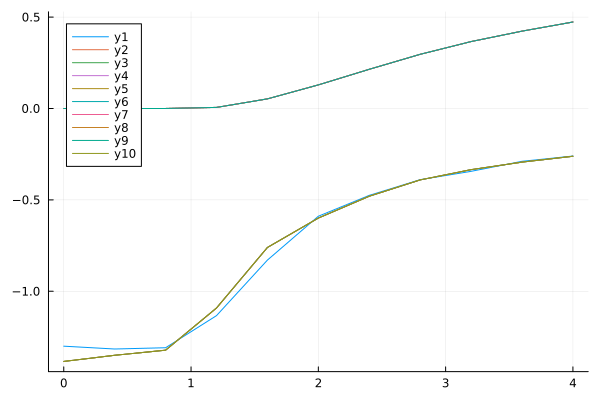

In [152]:
display(plot!(Ts,energies))

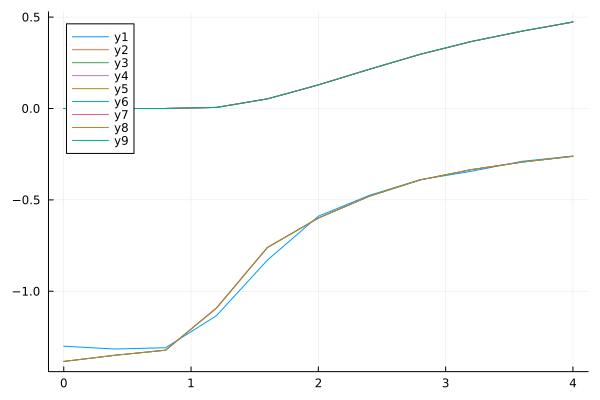

In [151]:
display(plot!(Ts,acceptance_rates))